**Imports**

In [123]:
!pip install pyccel
!pip install numba
import numpy as np
import scipy as sp
from scipy import special as ss
import scipy.linalg as lg
import matplotlib.pyplot as pl

import time
from time import process_time


from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

**Pure python function**

In [124]:
def analytique_pure(d,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha):
  iteration=0
  for alpha1 in range(0,d+1):
    for beta1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for beta2 in range(0,d-beta1+1):
          sum=0
          for i in range(0,3):
            alphai[0]=alpha1
            alphai[1]=alpha2
            alphai[2]=d-alpha1-alpha2
            alphai[i]=alphai[i]-1
            for j in range(0,3):
              betaj[1]=beta2
              betaj[2]=d-beta1-beta2
              betaj[0]=beta1
              betaj[j]=betaj[j]-1
              if alphai[0] >=0  and betaj[0] >=0  and alphai[1] >=0  and betaj[1] >=0 and alphai[2] >=0  and betaj[2] >=0 :
                c=C0[int(betaj[0]+alphai[0]),int(alphai[0])]/C0[d-1+d-1,d-1]
                c=c*C0[int(betaj[1]+alphai[1]),int(alphai[1])]
                Cij=c*C0[int(betaj[2]+alphai[2]),int(alphai[2])]
                sum=sum+invJTdLmada[i,j]*(0.5/C0[2*(d-1)+2,2])*Cij  
          KalphaBitha[iteration]=(d**2)*sum
          iteration=iteration+1
  return 0          

 

*test*

In [125]:
p=2
C0=sp.diag(sp.ones(600))
C0[:,0]=sp.ones(600)
for n in range(1,600):                        # Formule de pascal
     for m in range(1,n+1):
        C0[n,m]= C0[n-1,m-1]+C0[n-1,m]
JT=sp.eye(2)
iteration=0
ind=int(C0[p+2,2]**2)
KalphaBitha=np.zeros(ind)
alphai=np.zeros(3)
betaj=np.zeros(3)
Dlampda=np.array([[1,0],[0,1],[-1,-1]])                      # Dérivés des coordonnées barycentriques
invJTdLmada=np.zeros((3,3))
for i in range(3):
  for j in range(3):
    invJTdLmada[i,j]=sp.sum(Dlampda[i]*Dlampda[j])

analytique_pure(p,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha)
print(KalphaBitha)

[ 0.66666667  0.         -0.16666667  0.          0.66666667 -0.16666667
 -0.16666667 -0.16666667  0.33333333  0.         -0.33333333  0.
 -0.33333333 -0.16666667  0.16666667 -0.16666667 -0.16666667  0.
  0.          0.         -0.16666667 -0.33333333 -0.33333333  0.16666667
  0.66666667 -0.33333333 -0.33333333  0.66666667 -0.16666667  0.16666667
 -0.16666667 -0.16666667  0.         -0.16666667  0.16666667  0.33333333]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.eye is deprecated and will be removed in SciPy 2.0.0, use numpy.eye instead
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


**Pyccel accelerator**

In [126]:
@types('int','int','float[:]','float[:]','float[:,:]','float[:,:]','float[:]')
def analytique_pyccel(d,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha):
  iteration=0
  for alpha1 in range(0,d+1):
    for beta1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for beta2 in range(0,d-beta1+1):
          sum=0.
          for i in range(0,3):
            alphai[0]=alpha1
            alphai[1]=alpha2
            alphai[2]=d-alpha1-alpha2
            alphai[i]=alphai[i]-1
            for j in range(0,3):
              betaj[1]=beta2
              betaj[2]=d-beta1-beta2
              betaj[0]=beta1
              betaj[j]=betaj[j]-1
              if alphai[0] >=0  and betaj[0] >=0  and alphai[1] >=0  and betaj[1] >=0 and alphai[2] >=0  and betaj[2] >=0 :
                c=C0[int(betaj[0]+alphai[0]),int(alphai[0])]/C0[d-1+d-1,d-1]
                c=c*C0[int(betaj[1]+alphai[1]),int(alphai[1])]
                Cij=c*C0[int(betaj[2]+alphai[2]),int(alphai[2])]
                sum=sum+invJTdLmada[i,j]*(0.5/C0[2*(d-1)+2,2])*Cij  
          KalphaBitha[iteration]=(d**2)*sum
          iteration=iteration+1
  return 0       

In [127]:
analytique=epyccel(analytique_pyccel)

**Numba accelerator**

In [128]:
@njit
def analytique_numba(d,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha):
  iteration=0
  for alpha1 in range(0,d+1):
    for beta1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for beta2 in range(0,d-beta1+1):
          sum=0.
          for i in range(0,3):
            alphai[0]=alpha1
            alphai[1]=alpha2
            alphai[2]=d-alpha1-alpha2
            alphai[i]=alphai[i]-1
            for j in range(0,3):
              betaj[1]=beta2
              betaj[2]=d-beta1-beta2
              betaj[0]=beta1
              betaj[j]=betaj[j]-1
              if alphai[0] >=0  and betaj[0] >=0  and alphai[1] >=0  and betaj[1] >=0 and alphai[2] >=0  and betaj[2] >=0 :
                c=C0[int(betaj[0]+alphai[0]),int(alphai[0])]/C0[d-1+d-1,d-1]
                c=c*C0[int(betaj[1]+alphai[1]),int(alphai[1])]
                Cij=c*C0[int(betaj[2]+alphai[2]),int(alphai[2])]
                sum=sum+invJTdLmada[i,j]*(0.5/C0[2*(d-1)+2,2])*Cij  
          KalphaBitha[iteration]=(d**2)*sum
          iteration=iteration+1
  return 0       

**Inputs**

In [129]:
C0=sp.diag(sp.ones(600))
C0[:,0]=sp.ones(600)
for n in range(1,600):                        # Formule de pascal
     for m in range(1,n+1):
        C0[n,m]= C0[n-1,m-1]+C0[n-1,m]

JT=sp.eye(2)

alphai=np.zeros(3)
betaj=np.zeros(3)
Dlampda=np.array([[1,0],[0,1],[-1,-1]])
invJTdLmada=np.zeros((3,3))
for i in range(3):
  for j in range(3):
    invJTdLmada[i,j]=sp.sum(Dlampda[i]*Dlampda[j])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.eye is deprecated and will be removed in SciPy 2.0.0, use numpy.eye instead
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  from ipykernel import kernelapp as app


In [143]:
degremax=100

**time for pure function**

In [142]:
temCPUpur=[]                                               
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  alphai=np.zeros(3)
  betaj=np.zeros(3)
  iteration=0
  ind=int(C0[i+2,2]**2)
  KalphaBitha=np.zeros(ind)
  t1= process_time()
  analytique_pure(i,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha)
  t2= process_time()
  temCPUpur.append(t2-t1)

**Time for function with numba accelerator**

In [134]:
temCPUnumba=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  ind=int(C0[i+2,2]**2)
  KalphaBitha=np.zeros(ind)
  alphai=np.zeros(3)
  betaj=np.zeros(3)
  t1n= process_time()
  analytique_numba(i,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha)  
  t2n= process_time()
  temCPUnumba.append(t2n-t1n)

**Time for function with pyccel accelerator**

In [135]:
temCPUpyccel=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  ind=int(C0[i+2,2]**2)
  KalphaBitha=np.zeros(ind)
  alphai=np.zeros(3)
  betaj=np.zeros(3)
  t1P= process_time()
  analytique(i,iteration,alphai,betaj,C0,invJTdLmada,KalphaBitha)
  t2P= process_time()
  temCPUpyccel.append(t2P-t1P)

**Plots**

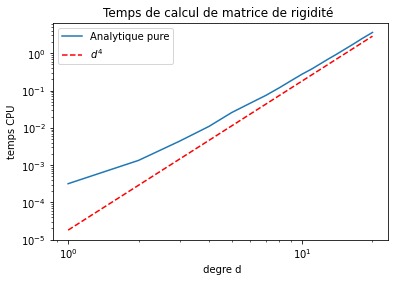

In [145]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpur,label='Analytique pure')
pl.grid()
pl.title("Temps de calcul de matrice de rigidité ")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=1.8*(10**(-5))
Z=cst*(Degre**4)
pl.plot(degre,Z,'r--',label='$d^4$')
pl.legend()
pl.grid()
pl.show()

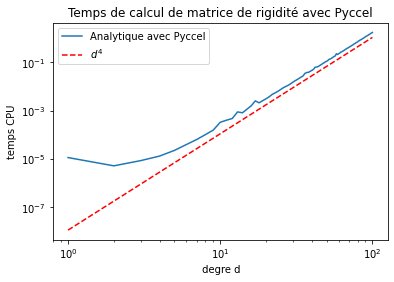

In [136]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpyccel,label='Analytique avec Pyccel')
pl.grid()
pl.title("Temps de calcul de matrice de rigidité avec Pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=1.1*(10**(-8))
Z=cst*(Degre**4)
pl.plot(degre,Z,'r--',label='$d^4$')
pl.legend()
pl.grid()
pl.show()

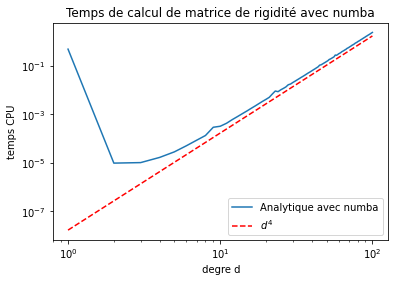

In [138]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUnumba,label='Analytique avec numba')
pl.grid()
pl.title("Temps de calcul de matrice de rigidité avec numba")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=1.7*(10**(-8))
Z=cst*(Degre**4)
pl.plot(degre,Z,'r--',label='$d^4$')
pl.legend()
pl.grid()
pl.show()

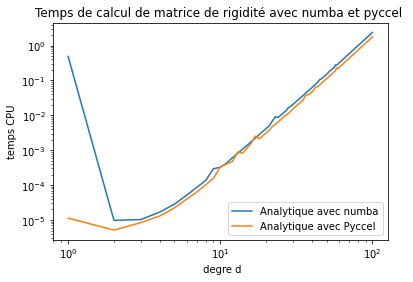

In [140]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUnumba,label='Analytique avec numba')
pl.plot(degre,temCPUpyccel,label='Analytique avec Pyccel')
#pl.plot(degre,temCPUpur,label='Analytique pure')
pl.grid()
pl.title("Temps de calcul de matrice de rigidité avec numba et pyccel ")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=3.1*(10**(-10))
Z=cst*(Degre**4)
#pl.plot(degre,Z,'r--',label='$d^4$')
pl.legend()
pl.grid()
pl.show()